## Social graphs & intercations
- Project Assignment
- Submission date: December 9th 2025

### Group 96
- Aryan Mirzazadeh - s204489
- Juan Manuel Rodriguez - s253505 
- Vladyslav Horbatenko - s254355

### Contributions

- Aryan: Worked on Part 1
- Juan: Worked on Part 2
- Vlad: Worked on Part 3

---

In [1]:
import io
import json
import os
import re
from collections import Counter
from pathlib import Path

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
import nltk
import numpy as np
import pandas as pd
import requests

from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.lines import Line2D
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

from networkx.algorithms.community import louvain_communities, modularity

try:
    from wordcloud import WordCloud
    print("WordCloud library loaded successfully!")
except ImportError:
    print("Installing wordcloud...")
    import subprocess
    subprocess.check_call(["pip", "install", "wordcloud"])
    from wordcloud import WordCloud
    print("WordCloud installed and loaded!")


WordCloud library loaded successfully!


# 1) Character network interaction analysis

## Create undirected weighted character interaction network

In [2]:
# Load data
DATA_DIR = Path("data")

local_character_connections = DATA_DIR / "character_connections_with_sentiment.json"
raw_character_connections_url = "https://raw.githubusercontent.com/rifolio/dtu-projects-2025-autumn/master/social-graphs/star-wars-original-trilogy/data/character_connections_with_sentiment.json"

if local_character_connections.exists():
    print(f"Loading character connections data from local file: {local_character_connections}")
    with open(local_character_connections, "r") as f:
        character_data = json.load(f)
else:
    print(f"Downloading character connections data from: {raw_character_connections_url}")
    r = requests.get(raw_character_connections_url, timeout=30)
    r.raise_for_status()
    character_data = json.loads(r.text)

print(f"✓ Loaded {len(character_data)} characters")

# Create undirected weighted graph
G = nx.Graph()

# Add nodes with sentiment as node attribute
for character, data in character_data.items():
    sentiment = data.get("sentiment")
    G.add_node(character, sentiment=sentiment)

# Add weighted edges
for character, data in character_data.items():
    connections = data.get("connections", {})
    for other_char, weight in connections.items():
        # Only add edge if both nodes exist (undirected, so we check to avoid duplicates)
        if G.has_node(other_char):
            if G.has_edge(character, other_char):
                # Update weight if edge exists (sum the weights from both directions)
                G[character][other_char]["weight"] += weight
            else:
                G.add_edge(character, other_char, weight=weight)

print("Network Statistics:")
print(f"  - Nodes: {G.number_of_nodes()}")
print(f"  - Edges: {G.number_of_edges()}")
print(f"  - Average degree: {2 * G.number_of_edges() / G.number_of_nodes():.2f}")

Loading character connections data from local file: data/character_connections_with_sentiment.json
✓ Loaded 113 characters
Network Statistics:
  - Nodes: 113
  - Edges: 313
  - Average degree: 5.54


***

## Network Visualization with ForceAtlas2 Layout

Visualizing the network using a force-directed layout with nodes colored by sentiment scores

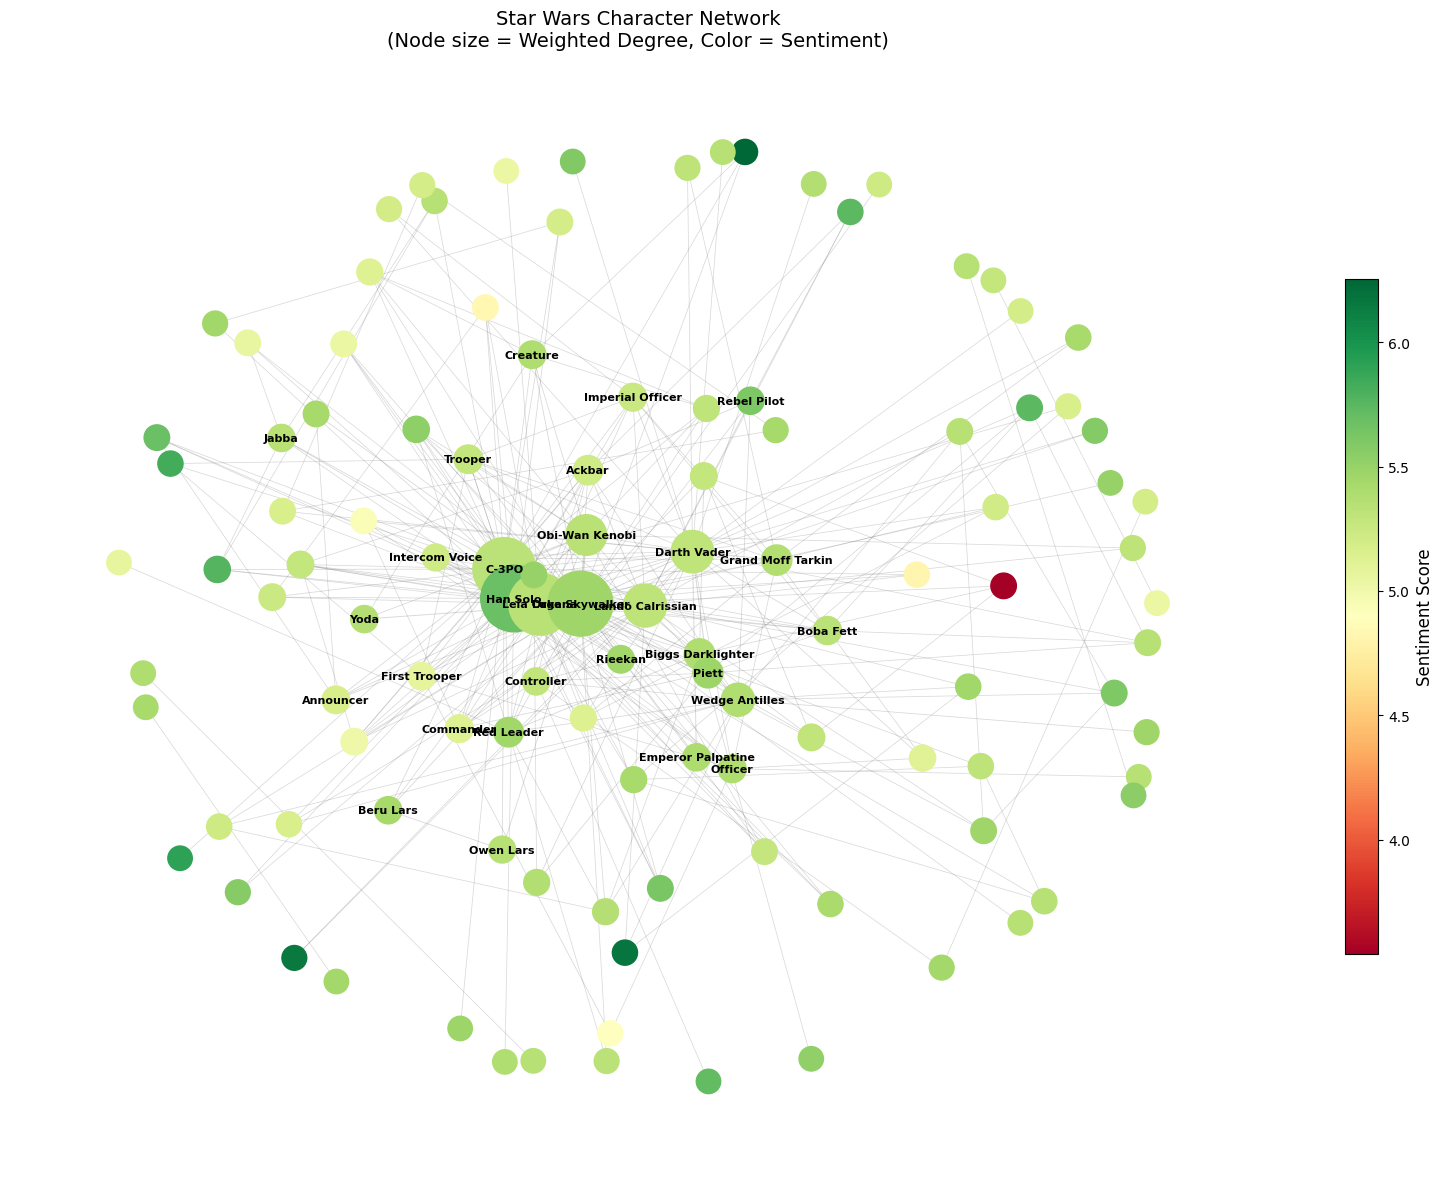

In [3]:
# Get sentiment values for coloring
sentiments = [G.nodes[n]["sentiment"] for n in G.nodes()]

# Replace None with median sentiment for visualization
valid_sentiments = [s for s in sentiments if s is not None]
median_sentiment = np.median(valid_sentiments)
sentiments_filled = [s if s is not None else median_sentiment for s in sentiments]

# Create color mapping
norm = Normalize(vmin=min(valid_sentiments), vmax=max(valid_sentiments))
cmap = cm.RdYlGn  # Red (negative) to Green (positive)
node_colors = [cmap(norm(s)) for s in sentiments_filled]

# Calculate node sizes based on degree
degrees = dict(G.degree(weight="weight"))
max_degree = max(degrees.values())
node_sizes = [300 + (degrees[n] / max_degree) * 2000 for n in G.nodes()]

# Use spring layout as ForceAtlas2 approximation (with weight consideration)
# NetworkX's spring_layout is similar to ForceAtlas2
pos = nx.spring_layout(G, k=2, iterations=100, seed=42, weight="weight")

# Visualization
fig, ax = plt.subplots(figsize=(16, 12))

# Draw edges with varying alpha based on weight
edge_weights = [G[u][v]["weight"] for u, v in G.edges()]
max_weight = max(edge_weights)
edge_alphas = [0.1 + 0.5 * (w / max_weight) for w in edge_weights]

nx.draw_networkx_edges(
    G,
    pos,
    alpha=0.3,
    width=[0.5 + 2 * (w / max_weight) for w in edge_weights],
    edge_color="gray",
    ax=ax,
)

# Draw nodes
nodes = nx.draw_networkx_nodes(
    G,
    pos,
    node_color=sentiments_filled,
    node_size=node_sizes,
    cmap=cmap,
    vmin=min(valid_sentiments),
    vmax=max(valid_sentiments),
    ax=ax,
)

# Add labels for major characters (high degree)
degree_threshold = np.percentile(list(degrees.values()), 75)
labels = {n: n for n in G.nodes() if degrees[n] >= degree_threshold}
nx.draw_networkx_labels(G, pos, labels, font_size=8, font_weight="bold", ax=ax)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.6)
cbar.set_label("Sentiment Score", fontsize=12)

ax.set_title(
    "Star Wars Character Network\n(Node size = Weighted Degree, Color = Sentiment)",
    fontsize=14,
)
ax.axis("off")
plt.tight_layout()
plt.show()

> Figure: Character interaction network, where node color is determined by the sentiment score. And most characters seem to have a neutral sentiment (around 5).

***

## Community Detection Analysis

### Approach 1) Sentiment-Based Communities

Grouping characters into communities based on their sentiment scores (low, medium, high sentiment).

In [4]:
# Sentiment-based community detection
# Use tertiles to create 3 sentiment-based communities

# Get valid sentiments and compute tertile thresholds
valid_sentiment_nodes = [
    (n, G.nodes[n]["sentiment"])
    for n in G.nodes()
    if G.nodes[n]["sentiment"] is not None
]
sentiment_values = sorted([s for _, s in valid_sentiment_nodes])

# Calculate tertile thresholds
tertile_1 = np.percentile(sentiment_values, 33.33)
tertile_2 = np.percentile(sentiment_values, 66.67)

print(f"Sentiment tertile thresholds: {tertile_1:.3f}, {tertile_2:.3f}")

# Assign nodes to sentiment-based communities
sentiment_communities = {0: set(), 1: set(), 2: set()}  # Low, Medium, High sentiment

for node in G.nodes():
    sentiment = G.nodes[node]["sentiment"]
    if sentiment is None:
        sentiment = median_sentiment  # Use median for missing values
    if sentiment <= tertile_1:
        sentiment_communities[0].add(node)
    elif sentiment <= tertile_2:
        sentiment_communities[1].add(node)
    else:
        sentiment_communities[2].add(node)

# Convert to list of sets for modularity calculation
sentiment_community_list = [sentiment_communities[i] for i in range(3)]

print("Sentiment-based communities:")
print(
    f"  - Low sentiment (≤{tertile_1:.3f}): {len(sentiment_communities[0])} characters"
)
print(
    f"  - Medium sentiment ({tertile_1:.3f}-{tertile_2:.3f}): {len(sentiment_communities[1])} characters"
)
print(
    f"  - High sentiment (>{tertile_2:.3f}): {len(sentiment_communities[2])} characters"
)

Sentiment tertile thresholds: 5.286, 5.430
Sentiment-based communities:
  - Low sentiment (≤5.286): 35 characters
  - Medium sentiment (5.286-5.430): 44 characters
  - High sentiment (>5.430): 34 characters


***

### Approach 2: Louvain Community Detection

Using NetworkX's Louvain algorithm which optimizes modularity to find communities based on network structure.

In [5]:
# Louvain community detection
louvain_communities_result = louvain_communities(G, weight="weight", seed=42)
print(f"Louvain detected {len(louvain_communities_result)} communities:\n")
for i, community in enumerate(louvain_communities_result):
    # Top 5 members by degree count
    members_by_degree = sorted(community, key=lambda x: degrees[x], reverse=True)[:5]
    print(f"Community {i+1} ({len(community)} members): {', '.join(members_by_degree)}")

Louvain detected 9 communities:

Community 1 (22 members): Han Solo, C-3PO, Leia Organa, Announcer, Rieekan
Community 2 (18 members): Lando Calrissian, Wedge Antilles, Ackbar, Rebel Pilot, Controller
Community 3 (2 members): Control Room Commander, Second Commander
Community 4 (34 members): Darth Vader, Grand Moff Tarkin, Piett, Trooper, Boba Fett
Community 5 (2 members): Gold Five, Massassi Intercom Voice
Community 6 (4 members): Derlin, Pilots, Hobbie, Lieutenant
Community 7 (2 members): Rebel Fighter, Rebel Captain
Community 8 (27 members): Luke Skywalker, Obi-Wan Kenobi, Biggs Darklighter, Red Leader, Creature
Community 9 (2 members): Porkins, Red Nine


***

### Modularity Comparison

In [6]:
# Calculate modularity for both community detection approaches
modularity_sentiment = modularity(G, sentiment_community_list, weight="weight")
modularity_louvain = modularity(G, louvain_communities_result, weight="weight")

# Create comparison table
comparison_df = pd.DataFrame(
    {
        "Community Detection Method": [
            "Sentiment-Based (3 communities)",
            f"Louvain ({len(louvain_communities_result)} communities)",
        ],
        "Number of Communities": [3, len(louvain_communities_result)],
        "Modularity": [f"{modularity_sentiment:.4f}", f"{modularity_louvain:.4f}"],
    }
)
print("MODULARITY COMPARISON:")
print(comparison_df.to_string(index=False))

MODULARITY COMPARISON:
     Community Detection Method  Number of Communities Modularity
Sentiment-Based (3 communities)                      3    -0.0940
        Louvain (9 communities)                      9     0.3334


Here we can see that the sentiment based communities is worse than guessing randomly to form communities.
While the louvain algorithm clearly finds a good structure for communities in the network
***

### Community Visualization

Visualizing both community detection approaches side by side.

/var/folders/vs/4fkzxbz13mj7pqtlqnh916m00000gn/T/ipykernel_23295/840464756.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10" if n_communities <= 10 else "tab20")


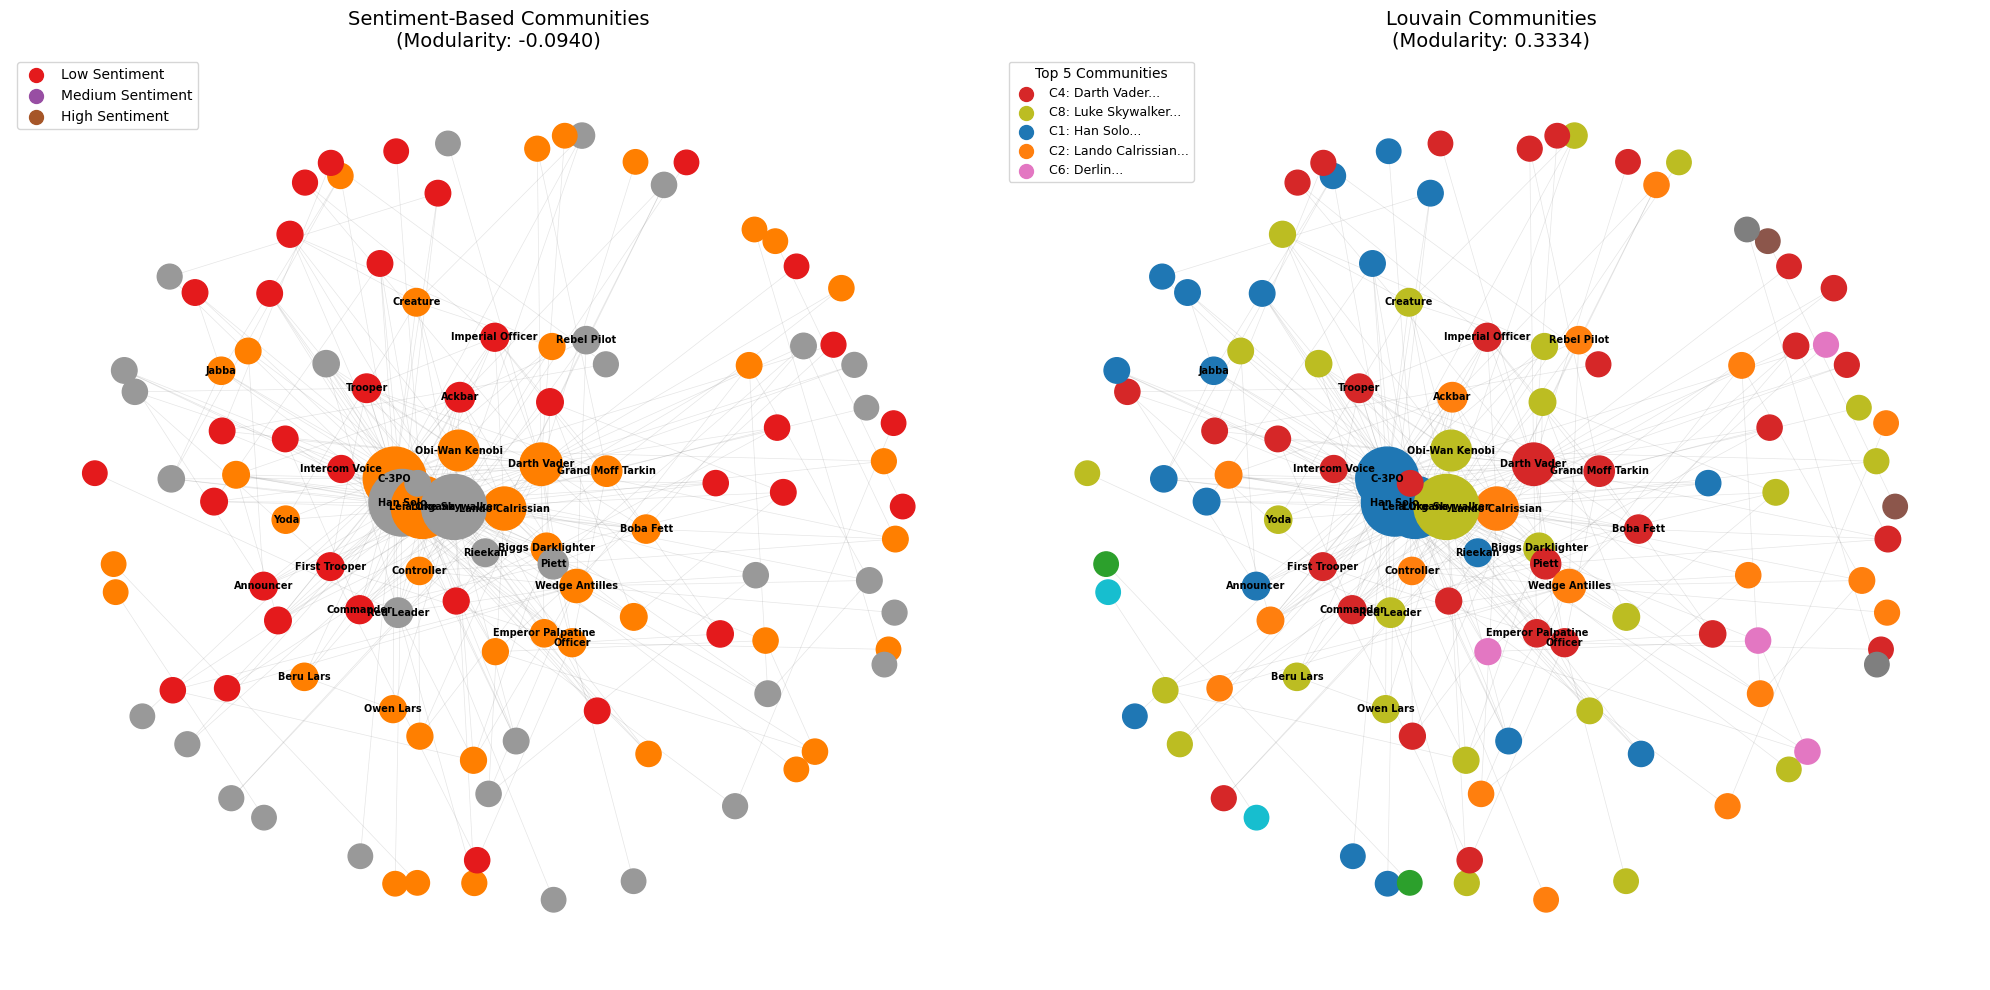

In [7]:
# Create node-to-community mappings
sentiment_node_community = {}
for comm_id, community in enumerate(sentiment_community_list):
    for node in community:
        sentiment_node_community[node] = comm_id

louvain_node_community = {}
for comm_id, community in enumerate(louvain_communities_result):
    for node in community:
        louvain_node_community[node] = comm_id


# Create colors for communities
def get_community_colors(node_community_map, n_communities):
    """Generate distinct colors for each community."""
    cmap = cm.get_cmap("tab10" if n_communities <= 10 else "tab20")
    colors = [cmap(node_community_map[node] / n_communities) for node in G.nodes()]
    return colors


# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

ax1 = axes[0]
sentiment_colors = get_community_colors(sentiment_node_community, 3)

nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.5, edge_color="gray", ax=ax1)
nodes1 = nx.draw_networkx_nodes(
    G,
    pos,
    node_color=[sentiment_node_community[n] for n in G.nodes()],
    node_size=node_sizes,
    cmap=cm.Set1,
    vmin=0,
    vmax=2,
    ax=ax1,
)
nx.draw_networkx_labels(G, pos, labels, font_size=7, font_weight="bold", ax=ax1)

ax1.set_title(
    f"Sentiment-Based Communities\n(Modularity: {modularity_sentiment:.4f})",
    fontsize=14,
)
ax1.axis("off")

# Add legend for sentiment communities
sentiment_labels = ["Low Sentiment", "Medium Sentiment", "High Sentiment"]
sentiment_cmap = cm.Set1
for i, label in enumerate(sentiment_labels):
    ax1.scatter([], [], c=[sentiment_cmap(i / 3)], s=100, label=label)
ax1.legend(loc="upper left", fontsize=10)

# ========== Louvain communities ==========
ax2 = axes[1]
n_louvain = len(louvain_communities_result)

nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.5, edge_color="gray", ax=ax2)
nodes2 = nx.draw_networkx_nodes(
    G,
    pos,
    node_color=[louvain_node_community[n] for n in G.nodes()],
    node_size=node_sizes,
    cmap=cm.tab10,
    vmin=0,
    vmax=n_louvain - 1,
    ax=ax2,
)
nx.draw_networkx_labels(G, pos, labels, font_size=7, font_weight="bold", ax=ax2)

ax2.set_title(
    f"Louvain Communities\n(Modularity: {modularity_louvain:.4f})", fontsize=14
)
ax2.axis("off")

# Add legend for Louvain communities (top 5 by size)
sorted_communities = sorted(
    enumerate(louvain_communities_result), key=lambda x: len(x[1]), reverse=True
)
louvain_cmap = cm.tab10
for idx, (comm_id, community) in enumerate(sorted_communities[:5]):
    top_member = max(community, key=lambda x: degrees[x])
    ax2.scatter(
        [],
        [],
        c=[louvain_cmap(comm_id / (n_louvain - 1))],
        s=100,
        label=f"C{comm_id+1}: {top_member}...",
    )
ax2.legend(loc="upper left", fontsize=9, title="Top 5 Communities")

plt.tight_layout()
plt.show()

***

### Key Findings:

1. **Network Structure**: The Star Wars character network contains 113 characters with 313 weighted edges. The main characters (Han Solo, C-3PO, Leia Organa, Luke Skywalker) form the core of the network.

2. **Sentiment Distribution**: Character sentiment scores range from 3.54 to 6.25, with most characters clustered around 5.2-5.5.

3. **Community Detection Comparison**:
   - **Sentiment-Based**: Dividing characters by sentiment tertiles yields a negative modularity (-0.094), indicating that sentiment does not align well with the network's structural communities.
   - **Louvain Algorithm**: Detects 9 communities with positive modularity (0.333), revealing meaningful structural groups such as:
     - Imperial characters (Darth Vader, Grand Moff Tarkin, Piett)
     - Rebel heroes (Luke Skywalker, Obi-Wan Kenobi)
     - Main trio and associates (Han Solo, C-3PO, Leia Organa)
     - Rebel fleet (Lando Calrissian, Wedge Antilles, Ackbar)

The Louvain algorithm significantly outperforms sentiment-based clustering, confirming that character interactions in the movies form natural structural communities that don't necessarily correlate with their dialogue sentiment.
***

# 2) Bipartite network analysis

For each location $l \in L$ in the dataset, we maintained a dictionary structure containing:

- A set of characters $C_l = \{c_1, c_2, \ldots, c_n\}$ appearing in location $l$
- Appearance counts $w(c,l)$ representing the number of scenes in which character $c$ appears at location $l$
- A sentiment score $s(l)$ representing the emotional valence of location $l$

We formalized the character-location relationships as a bipartite graph $G = (C \cup L, E)$, where:

- $C$ is the set of character nodes
- $L$ is the set of location nodes with sentiment attribute $s(l)$
- $E \subseteq C \times L$ is the set of edges connecting characters to locations

Each edge $(c,l) \in E$ is weighted by the appearance count $w(c,l)$, representing the frequency of character $c$ appearing at location $l$.


## Bipartite network visualization

Node visual encoding followed these conventions:
- **Shape**: Circles for characters, squares for locations
- **Size**: Proportional to weighted degree $\deg_w(v) = \sum_{u \in N(v)} w(v,u)$, where $N(v)$ denotes the neighbors of node $v$
- **Color**: Mapped to sentiment scores using the RdYlGn (Red-Yellow-Green) colormap, where red indicates negative sentiment, yellow neutral, and green positive

Edge thickness was scaled proportionally to normalized weights.

Loading location characters data from local file: data/location_characters_with_sentiment.json
✓ Loaded location characters data with 94 locations


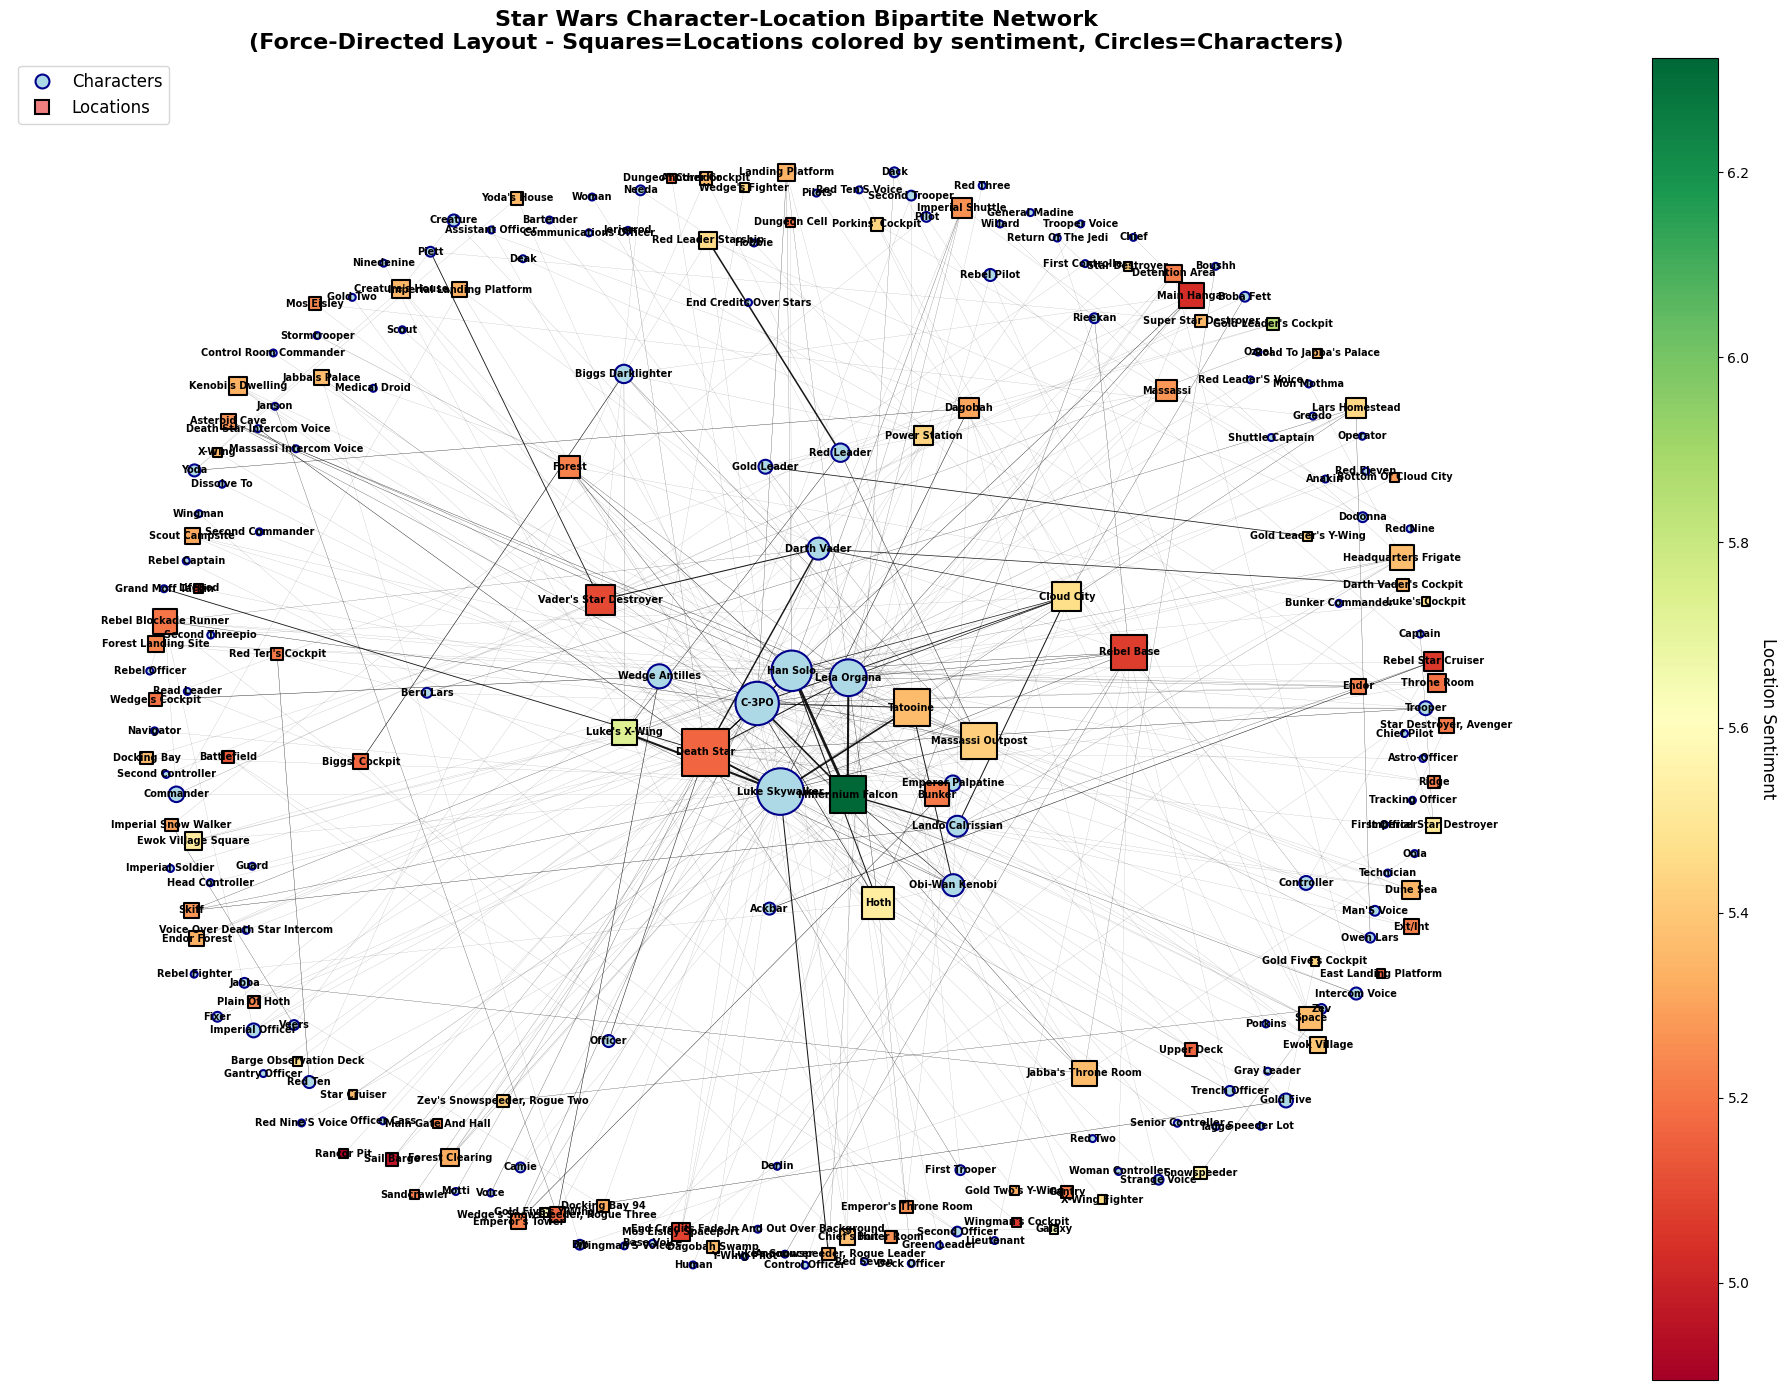

In [8]:
# Load location_characters_with_sentiment.json
local_location_characters = DATA_DIR / "location_characters_with_sentiment.json"
raw_location_characters_url = "https://raw.githubusercontent.com/rifolio/dtu-projects-2025-autumn/master/social-graphs/star-wars-original-trilogy/data/location_characters_with_sentiment.json"

if local_location_characters.exists():
    print(f"Loading location characters data from local file: {local_location_characters}")
    with open(local_location_characters, "r") as f:
        location_characters_dict = json.load(f)
else:
    print(f"Downloading location characters data from: {raw_location_characters_url}")
    r = requests.get(raw_location_characters_url, timeout=30)
    r.raise_for_status()
    location_characters_dict = json.loads(r.text)

print(f"✓ Loaded location characters data with {len(location_characters_dict)} locations")

# Create bipartite graph
G_bipartite = nx.Graph()

# Add nodes and edges
for location, data in location_characters_dict.items():
    G_bipartite.add_node(
        location, bipartite=0, sentiment=data["sentiment"], node_type="location"
    )

    for char, count in data["characters"].items():
        if char not in G_bipartite:
            G_bipartite.add_node(char, bipartite=1, node_type="character")
        G_bipartite.add_edge(location, char, weight=count)

# Separate nodes by type
char_nodes = [
    node for node, d in G_bipartite.nodes(data=True) if d["node_type"] == "character"
]
loc_nodes = [
    node for node, d in G_bipartite.nodes(data=True) if d["node_type"] == "location"
]

# Calculate degrees for filtering
location_degrees = {loc: G_bipartite.degree(loc) for loc in loc_nodes}

# Get sentiments and calculate min/max
sentiments = [
    G_bipartite.nodes[node]["sentiment"]
    for node in loc_nodes
    if G_bipartite.nodes[node]["sentiment"] is not None
]
min_sentiment = min(sentiments) if sentiments else 1.0
max_sentiment = max(sentiments) if sentiments else 10.0

# Get sentiments for location nodes (use mid value for None)
sentiments_for_colors = [
    (
        G_bipartite.nodes[node]["sentiment"]
        if G_bipartite.nodes[node]["sentiment"] is not None
        else (min_sentiment + max_sentiment) / 2
    )
    for node in loc_nodes
]

# Create figure
fig, ax = plt.subplots(figsize=(18, 14))

# Use spring layout for bipartite network
pos_bipartite = nx.spring_layout(
    G_bipartite, k=1.5, iterations=50, seed=42, weight="weight"
)

# Node sizes
char_node_sizes = [G_bipartite.degree(node) * 25 for node in char_nodes]
loc_node_sizes = [G_bipartite.degree(node) * 40 for node in loc_nodes]

# Draw character nodes (circles)
nx.draw_networkx_nodes(
    G_bipartite,
    pos_bipartite,
    nodelist=char_nodes,
    node_size=char_node_sizes,
    node_color="lightblue",
    edgecolors="darkblue",
    linewidths=1.5,
    ax=ax,
)

# Draw location nodes (squares) with sentiment-based colors
nx.draw_networkx_nodes(
    G_bipartite,
    pos_bipartite,
    nodelist=loc_nodes,
    node_size=loc_node_sizes,
    node_shape="s",
    node_color=sentiments_for_colors,
    cmap="RdYlGn",
    vmin=min_sentiment,
    vmax=max_sentiment,
    edgecolors="black",
    linewidths=1.5,
    ax=ax,
)

# Draw edges
edges_bi = G_bipartite.edges()
weights_bi = [G_bipartite[u][v]["weight"] for u, v in edges_bi]
max_weight_bi = max(weights_bi) if weights_bi else 1
edge_widths_bi = [w / max_weight_bi * 2 for w in weights_bi]

nx.draw_networkx_edges(
    G_bipartite,
    pos_bipartite,
    width=edge_widths_bi,
    alpha=0.9,
    edge_color="black",
    ax=ax,
)

# Draw all character labels
nx.draw_networkx_labels(
    G_bipartite,
    pos_bipartite,
    labels={node: node if node in char_nodes else "" for node in G_bipartite.nodes()},
    font_size=7,
    font_weight="bold",
    ax=ax,
)

# Draw ALL location labels with same font size
nx.draw_networkx_labels(
    G_bipartite,
    pos_bipartite,
    labels={node: node if node in loc_nodes else "" for node in G_bipartite.nodes()},
    font_size=7,
    font_color="black",
    font_weight="bold",
    ax=ax,
)

# Add colorbar for sentiment
sm = plt.cm.ScalarMappable(
    cmap="RdYlGn", norm=plt.Normalize(vmin=min_sentiment, vmax=max_sentiment)
)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Location Sentiment", rotation=270, labelpad=20, fontsize=12)

# Create custom legend to avoid overlap
legend_elements = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="Characters",
        markerfacecolor="lightblue",
        markeredgecolor="darkblue",
        markersize=10,
        markeredgewidth=1.5,
    ),
    Line2D(
        [0],
        [0],
        marker="s",
        color="w",
        label="Locations",
        markerfacecolor="lightcoral",
        markeredgecolor="black",
        markersize=10,
        markeredgewidth=1.5,
    ),
]
ax.legend(handles=legend_elements, loc="upper left", fontsize=12)

ax.set_title(
    "Star Wars Character-Location Bipartite Network\n(Force-Directed Layout - Squares=Locations colored by sentiment, Circles=Characters)",
    fontsize=16,
    fontweight="bold",
)
ax.axis("off")
plt.tight_layout()
plt.show()

> Figure: Bipartite network of characters and locations in the Star Wars original trilogy.
***

## Bipartite network sentiment statistics

In [9]:
print("Location sentiment statistics:")
print(f"Number of characters: {G_bipartite.number_of_nodes() - len(loc_nodes)}")
print(f"Number of locations: {len(loc_nodes)}")
print(f"Number of connections: {G_bipartite.number_of_edges()}")
print(f"Min sentiment: {min_sentiment:.3f}, Max sentiment: {max_sentiment:.3f}")

Location sentiment statistics:
Number of characters: 128
Number of locations: 94
Number of connections: 378
Min sentiment: 4.895, Max sentiment: 6.324


***

### Sentiment Projection from Locations to Characters

To transfer emotional context from locations to characters, we employed a weighted averaging scheme. For each character $c \in C$, we computed a projected sentiment score $S(c)$ based on all locations $L_c \subseteq L$ to which the character is connected:

$$S(c) = \frac{\sum_{l \in L_c} w(c, l) \cdot s(l)}{\sum_{l \in L_c} w(c, l)}$$

where:

- $L_c = \{l \in L : (c, l) \in E\}$ is the set of locations visited by character $c$
- $w(c,l)$ is the edge weight (appearance count)
- $s(l)$ is the sentiment score of location $l$

This formulation ensures that characters appearing more frequently in certain locations are more strongly influenced by those locations' sentiment scores. Characters with no valid location sentiments were assigned null values and excluded from sentiment-based analyses.

## Bipartite Graph Projection to Character Network

To analyze character relationships mediated by shared locations, we projected the bipartite graph onto the character space, creating a unipartite character network $G' = (C, E')$.

For each location $l \in L$ with connected characters $C_l = \{c_1, c_2, \ldots, c_n\}$, we created edges between all character pairs $(c_i, c_j)$ where $i \neq j$. The weight of each projected edge represents the strength of co-occurrence through shared locations.

The edge weight between characters $c_i$ and $c_j$ through location $l$ was computed as:

$$w_l(c_i, c_j) = \min(w(c_i, l), w(c_j, l))$$

This conservative estimate uses the minimum appearance count, ensuring that edge weights reflect genuine co-presence rather than independent visits to the same location.

When multiple locations connect the same character pair, we summed their contributions:

$$W(c_i, c_j) = \sum_{l \in L_{ij}} w_l(c_i, c_j)$$

where $L_{ij} = \{l \in L : (c_i, l) \in E \wedge (c_j, l) \in E\}$ is the set of locations shared by both characters.

The projection algorithm transforms spatial co-occurrence into direct character relationships, enabling network analysis techniques such as community detection and centrality measures on the character space while preserving the sentiment information inherited from locations.



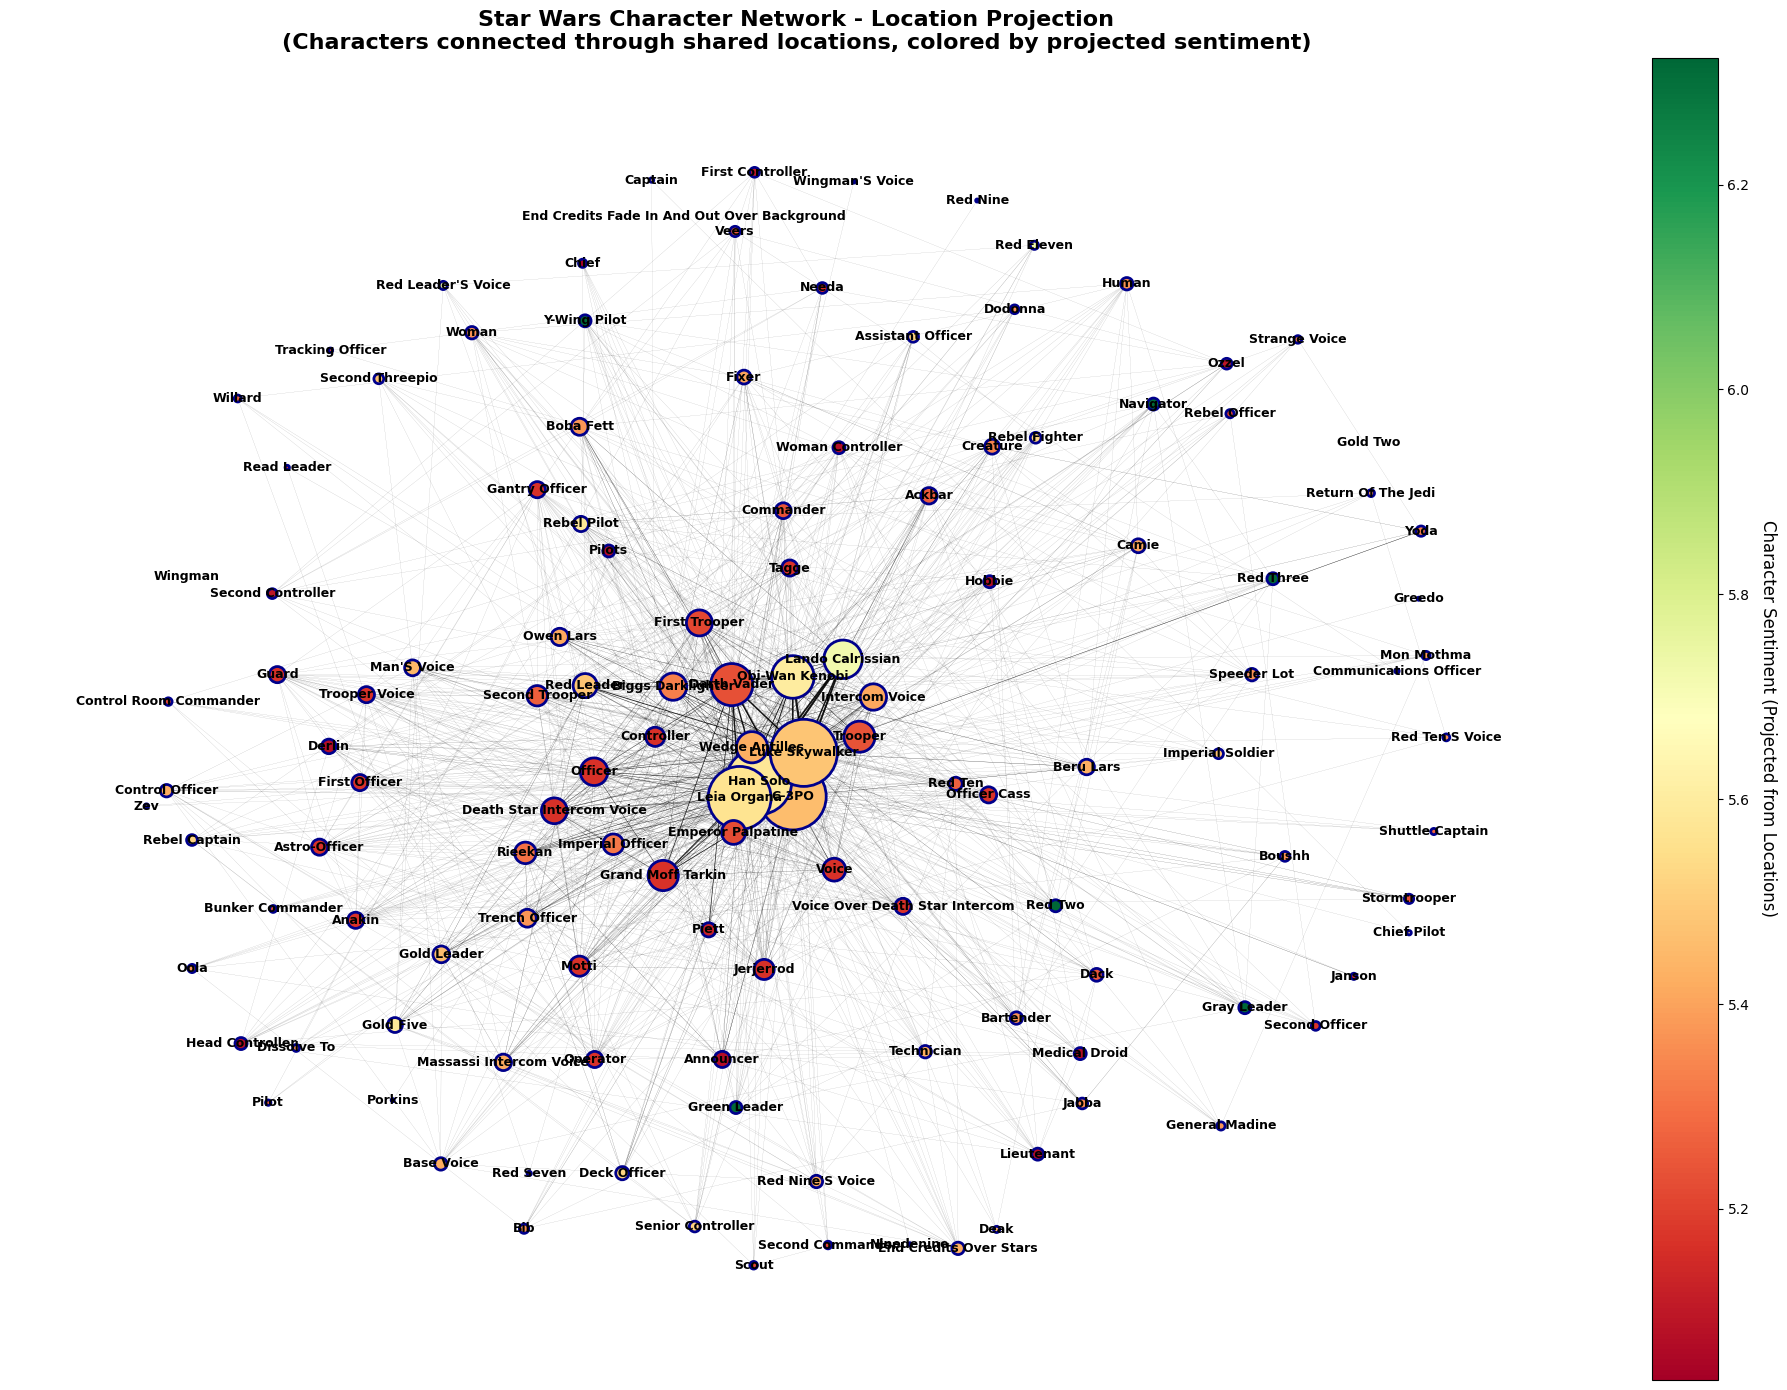

In [10]:
# get character sentiments based on connected locations sentiments
character_sentiments_subset = {}

for char in char_nodes:
    connected_locations = [n for n in G_bipartite.neighbors(char) if n in loc_nodes]
    if not connected_locations:
        character_sentiments_subset[char] = None
        continue

    weighted_sum = 0
    total_weight = 0
    for loc in connected_locations:
        weight = G_bipartite[char][loc]["weight"]
        sentiment = G_bipartite.nodes[loc]["sentiment"]
        if sentiment is not None:
            weighted_sum += sentiment * weight
            total_weight += weight

    if total_weight > 0:
        character_sentiments_subset[char] = weighted_sum / total_weight
    else:
        character_sentiments_subset[char] = None


# Create character-to-character projection graph
G_projection = nx.Graph()

# Add all character nodes with projected sentiments
for char in char_nodes:
    G_projection.add_node(char, sentiment=character_sentiments_subset[char])

# For each location, connect all pairs of characters that appear in it
for location in loc_nodes:
    # Get all characters connected to this location
    chars_in_location = [n for n in G_bipartite.neighbors(location) if n in char_nodes]

    # Connect all pairs of characters
    for i in range(len(chars_in_location)):
        for j in range(i + 1, len(chars_in_location)):
            char1 = chars_in_location[i]
            char2 = chars_in_location[j]

            # Get weights (how many times each character appears in this location)
            weight1 = G_bipartite[char1][location]["weight"]
            weight2 = G_bipartite[char2][location]["weight"]

            # Edge weight is the minimum of the two (conservative estimate of co-occurrence)
            edge_weight = min(weight1, weight2)

            # If edge already exists, add to its weight
            if G_projection.has_edge(char1, char2):
                G_projection[char1][char2]["weight"] += edge_weight
            else:
                G_projection.add_edge(char1, char2, weight=edge_weight)

# Get character sentiments for coloring
char_sentiments_proj = [
    (
        G_projection.nodes[node]["sentiment"]
        if G_projection.nodes[node]["sentiment"] is not None
        else None
    )
    for node in G_projection.nodes()
]
char_sentiments_proj_clean = [s for s in char_sentiments_proj if s is not None]

min_sentiment_proj = (
    min(char_sentiments_proj_clean) if char_sentiments_proj_clean else 1.0
)
max_sentiment_proj = (
    max(char_sentiments_proj_clean) if char_sentiments_proj_clean else 10.0
)

char_sentiments_for_colors_proj = [
    (
        G_projection.nodes[node]["sentiment"]
        if G_projection.nodes[node]["sentiment"] is not None
        else (min_sentiment_proj + max_sentiment_proj) / 2
    )
    for node in G_projection.nodes()
]

# Create figure
fig, ax = plt.subplots(figsize=(18, 14))

# Use spring layout
pos_projection = nx.spring_layout(
    G_projection, k=1.5, iterations=50, seed=42, weight="weight"
)

# Node sizes based on degree
node_sizes = [
    G_projection.degree(node, weight="weight") * 5 for node in G_projection.nodes()
]

# Draw character nodes with projected sentiment colors
nx.draw_networkx_nodes(
    G_projection,
    pos_projection,
    node_size=node_sizes,
    node_color=char_sentiments_for_colors_proj,
    cmap="RdYlGn",
    vmin=min_sentiment_proj,
    vmax=max_sentiment_proj,
    edgecolors="darkblue",
    linewidths=2,
    ax=ax,
)

# Draw edges
edges_proj = G_projection.edges()
weights_proj = [G_projection[u][v]["weight"] for u, v in edges_proj]
max_weight_proj = max(weights_proj) if weights_proj else 1
edge_widths_proj = [w / max_weight_proj * 4 for w in weights_proj]

nx.draw_networkx_edges(
    G_projection,
    pos_projection,
    width=edge_widths_proj,
    alpha=0.9,
    edge_color="black",
    ax=ax,
)

# Draw labels
nx.draw_networkx_labels(
    G_projection,
    pos_projection,
    font_size=9,
    font_weight="bold",
    ax=ax,
)

# Add colorbar for sentiment
sm = plt.cm.ScalarMappable(
    cmap="RdYlGn", norm=plt.Normalize(vmin=min_sentiment_proj, vmax=max_sentiment_proj)
)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label(
    "Character Sentiment (Projected from Locations)",
    rotation=270,
    labelpad=20,
    fontsize=12,
)

ax.set_title(
    "Star Wars Character Network - Location Projection\n(Characters connected through shared locations, colored by projected sentiment)",
    fontsize=16,
    fontweight="bold",
)
ax.axis("off")
plt.tight_layout()
plt.show()

> Figure: Locations projected onto characters and sentiment of locations spreaded between them.

---

## Projection graph statistics

In [11]:
print(f"Number of characters: {G_projection.number_of_nodes()}")
print(f"Number of connections: {G_projection.number_of_edges()}")
print(
    f"Min sentiment: {min_sentiment_proj:.3f}, Max sentiment: {max_sentiment_proj:.3f}"
)

# mean of the projected character sentiments
valid_sentiments = [s for s in char_sentiments_proj if s is not None]
mean_sentiment = np.mean(valid_sentiments) if valid_sentiments else None
print(
    f"Mean projected character sentiment: {mean_sentiment:.3f}"
    if mean_sentiment is not None
    else "Mean projected character sentiment: N/A"
)

Number of characters: 128
Number of connections: 1141
Min sentiment: 5.033, Max sentiment: 6.324
Mean projected character sentiment: 5.356


# 3) Sentiment Analysis

In [12]:
# Create figures directory
FIGURES_DIR = Path("figures")
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# Minimum word counts for analysis validity
MIN_WORDS_PRIMARY = 0
MIN_WORDS_SECONDARY = 0

# Sentiment thresholds (labMT neutral is ~5.0)
NEUTRAL = 5.3
SENTIMENT_DELTA = 1.0  # Words with |happiness - 5| > 1.0 are "sentiment-bearing"

# Load stopwords from NLTK
try:
    STOP_WORDS = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    STOP_WORDS = set(stopwords.words('english'))

print(f"Loaded {len(STOP_WORDS)} stopwords from NLTK")
print(f"MIN_WORDS_PRIMARY: {MIN_WORDS_PRIMARY}, MIN_WORDS_SECONDARY: {MIN_WORDS_SECONDARY}")

Loaded 198 stopwords from NLTK
MIN_WORDS_PRIMARY: 0, MIN_WORDS_SECONDARY: 0


In [13]:
# Load character and location dialogues
char_dialogues_path = DATA_DIR / "character_dialogues.json"
location_dialogues_path = DATA_DIR / "location_dialogues.json"

print(f"Loading character dialogues from: {char_dialogues_path}")
with open(char_dialogues_path, "r", encoding="utf-8") as f:
    character_dialogues = json.load(f)
print(f"✓ Loaded dialogues for {len(character_dialogues)} characters")

print(f"\nLoading location dialogues from: {location_dialogues_path}")
with open(location_dialogues_path, "r", encoding="utf-8") as f:
    location_dialogues = json.load(f)
print(f"✓ Loaded dialogues for {len(location_dialogues)} locations")

Loading character dialogues from: data/character_dialogues.json
✓ Loaded dialogues for 45 characters

Loading location dialogues from: data/location_dialogues.json
✓ Loaded dialogues for 137 locations


In [14]:
# Helper functions for sentiment analysis
def tokenize(text: str) -> list:
    return re.findall(r"[a-z']+", text.lower())

def get_word_stem_variants(word: str) -> list:
    """Handles: -s, -es, -ed, -ing, -ly, -er, -est, -ness, -ment, -tion, -'s (possessive)"""
    variants = [word]  # Always try original first
    
    if len(word) < 3:
        return variants
    
    # Handle possessive 's: Luke's -> Luke, character's -> character
    if word.endswith("'s") and len(word) > 3:
        variants.append(word[:-2])
    
    # -ing: walking -> walk, running -> run
    if word.endswith('ing') and len(word) > 4:
        base = word[:-3]
        variants.append(base)
        variants.append(base + 'e')
        if len(base) >= 2 and base[-1] == base[-2]:
            variants.append(base[:-1])
    
    # -ed: walked -> walk, hoped -> hope
    if word.endswith('ed') and len(word) > 3:
        base = word[:-2]
        variants.append(base)
        variants.append(base + 'e')
        if word.endswith('ied'):
            variants.append(word[:-3] + 'y')
        if len(base) >= 2 and base[-1] == base[-2]:
            variants.append(base[:-1])
    
    # -s: cats -> cat, boxes -> box
    if word.endswith('s') and len(word) > 2:
        variants.append(word[:-1])
        if word.endswith('es') and len(word) > 3:
            variants.append(word[:-2])
            if word.endswith('ies'):
                variants.append(word[:-3] + 'y')
            if word.endswith('ves'):
                variants.append(word[:-3] + 'f')
                variants.append(word[:-3] + 'fe')
    
    # -ly: quickly -> quick
    if word.endswith('ly') and len(word) > 3:
        variants.append(word[:-2])
        if word.endswith('ily'):
            variants.append(word[:-3] + 'y')
    
    # -er: faster -> fast
    if word.endswith('er') and len(word) > 3:
        base = word[:-2]
        variants.append(base)
        variants.append(base + 'e')
        if len(base) >= 2 and base[-1] == base[-2]:
            variants.append(base[:-1])
    
    # -est: fastest -> fast
    if word.endswith('est') and len(word) > 4:
        base = word[:-3]
        variants.append(base)
        variants.append(base + 'e')
        if len(base) >= 2 and base[-1] == base[-2]:
            variants.append(base[:-1])
    
    # -ness: happiness -> happy
    if word.endswith('ness') and len(word) > 5:
        base = word[:-4]
        variants.append(base)
        if word.endswith('iness'):
            variants.append(word[:-5] + 'y')
    
    # -ment: movement -> move
    if word.endswith('ment') and len(word) > 5:
        variants.append(word[:-4])
        variants.append(word[:-4] + 'e')
    
    # -tion/-sion: creation -> create
    if (word.endswith('tion') or word.endswith('sion')) and len(word) > 5:
        base = word[:-4]
        variants.append(base)
        variants.append(base + 'e')
        variants.append(base + 'te')
    
    # Remove duplicates while preserving order
    seen = set()
    unique_variants = []
    for v in variants:
        if v not in seen and len(v) >= 2:
            seen.add(v)
            unique_variants.append(v)
    
    return unique_variants

def lookup_sentiment(word: str, lexicon: dict) -> tuple:
    """Try each variant to find sentiment score"""
    for variant in get_word_stem_variants(word):
        if variant in lexicon:
            return lexicon[variant], variant
    return None, None

In [15]:

# Load sentiment lexicon (labMT dataset)
local_sentiment_data = DATA_DIR / "Data_Set_S1.txt"
raw_sentiment_url = "https://raw.githubusercontent.com/rifolio/dtu-projects-2025-autumn/master/social-graphs/data/Data_Set_S1.txt"

if local_sentiment_data.exists():
    print(f"Loading sentiment data from local file: {local_sentiment_data}")
    sentiment_df = pd.read_csv(local_sentiment_data, sep="\t", skiprows=2, header=0)
else:
    print(f"Downloading sentiment data from: {raw_sentiment_url}")
    r = requests.get(raw_sentiment_url, timeout=30)
    r.raise_for_status()
    with io.StringIO(r.text) as fh:
        sentiment_df = pd.read_csv(fh, sep="\t", skiprows=2, header=0)

# Clean up data types
sentiment_df["word"] = sentiment_df["word"].astype("string")
for col in ["twitter_rank", "google_rank", "nyt_rank", "lyrics_rank"]:
    if col in sentiment_df.columns:
        sentiment_df[col] = sentiment_df[col].replace("--", np.nan)
        sentiment_df[col] = pd.to_numeric(sentiment_df[col], errors="coerce").astype("Int64")

# word -> happiness score mapping
word_to_happiness = dict(zip(sentiment_df["word"], sentiment_df["happiness_average"]))
print(f"✓ Loaded {len(word_to_happiness)} words from sentiment lexicon")

✓ Loaded 10222 words from sentiment lexicon


In [16]:
# Sentiment computation functions
def sentiment_score(text: str, 
                    use_lens: bool = True,
                    exclude_stopwords: bool = True,
                    use_stemming: bool = True) -> tuple:
    """
    Compute sentiment score using consistent tokenization and optional stemming.
    
    Returns:
        Tuple of (sentiment score or None, count of scored words)
    """
    tokens = tokenize(text)
    
    scores = []
    for token in tokens:
        if exclude_stopwords and token in STOP_WORDS:
            continue
        
        # Look up sentiment with optional stemming
        if use_stemming:
            score, matched = lookup_sentiment(token, word_to_happiness)
        else:
            score = word_to_happiness.get(token)
        
        if score is not None:
            if use_lens:
                if abs(score - NEUTRAL) > SENTIMENT_DELTA:
                    scores.append(score)
            else:
                scores.append(score)
    
    if scores:
        return sum(scores) / len(scores), len(scores)
    return None, 0

def compute_sentiments(dialogues: dict, min_words: int = MIN_WORDS_SECONDARY) -> dict:
    """
    Compute sentiment scores for a collection of dialogues (locations or characters).
    Uses lens approach and excludes stopwords.
    """
    results = {}
    for name, lines in dialogues.items():
        full_text = " ".join(lines) if lines else ""
        wc = sum(len(tokenize(line)) for line in lines)
        score, scored_count = sentiment_score(full_text, use_lens=True, exclude_stopwords=True)
        
        # Quality label
        if wc >= MIN_WORDS_PRIMARY:
            quality = "high"
        elif wc >= MIN_WORDS_SECONDARY:
            quality = "medium"
        else:
            quality = "low"
            
        results[name] = {
            'sentiment': score,
            'word_count': wc,
            'scored_words': scored_count,
            'quality': quality
        }
    return results

In [17]:
location_sentiments = compute_sentiments(location_dialogues)

# Compute word counts for locations
location_word_counts = {loc: data['word_count'] for loc, data in location_sentiments.items()}

# Filter to locations with sufficient content
valid_locations = {
    k: v['sentiment'] for k, v in location_sentiments.items()
    if v['sentiment'] is not None and v['word_count'] >= MIN_WORDS_SECONDARY
}

print(f"\nTotal locations: {len(location_sentiments)}")
print(f"Locations with >= {MIN_WORDS_SECONDARY} words: {len(valid_locations)}")

if valid_locations:
    loc_scores = list(valid_locations.values())
    print(f"\nLocation Sentiment Statistics:")
    print(f"  Min: {min(loc_scores):.4f}")
    print(f"  Max: {max(loc_scores):.4f}")
    print(f"  Mean: {np.mean(loc_scores):.4f}")
    print(f"  Std Dev: {np.std(loc_scores):.4f}")


Total locations: 137
Locations with >= 0 words: 136

Location Sentiment Statistics:
  Min: 3.1300
  Max: 7.5133
  Mean: 5.1133
  Std Dev: 0.7764


In [18]:
character_sentiments = compute_sentiments(character_dialogues)

# Compute word counts for characters
word_counts = {char: data['word_count'] for char, data in character_sentiments.items()}

# Also create char_sentiments_lens for compatibility
char_sentiments_lens = character_sentiments

valid_characters = {
    k: v['sentiment'] for k, v in character_sentiments.items()
    if v['sentiment'] is not None and v['word_count'] >= MIN_WORDS_PRIMARY
}

print(f"\nTotal characters: {len(character_sentiments)}")
print(f"Characters with >= {MIN_WORDS_PRIMARY} words: {len(valid_characters)}")

if valid_characters:
    char_scores = list(valid_characters.values())
    print(f"\nCharacter Sentiment Statistics:")
    print(f"  Min: {min(char_scores):.4f}")
    print(f"  Max: {max(char_scores):.4f}")
    print(f"  Mean: {np.mean(char_scores):.4f}")
    print(f"  Std Dev: {np.std(char_scores):.4f}")


Total characters: 45
Characters with >= 0 words: 37

Character Sentiment Statistics:
  Min: 3.0400
  Max: 6.9700
  Mean: 5.3615
  Std Dev: 0.8550


In [19]:
# TF-IDF weighted sentiment computation function
def compute_tfidf_weighted_sentiments(dialogues: dict, 
                                      wc_dict: dict = None,
                                      use_lens: bool = True,
                                      use_stopwords: bool = True,
                                      use_stemming: bool = True,
                                      min_df: int = 2,
                                      entity_type: str = "entity"):
    """
    Compute TF-IDF weighted sentiment scores for entities (characters or locations).
    
    Args:
        dialogues: Dict of {entity_name: [lines]} 
        wc_dict: Dict of {entity_name: word_count} - if None, computed internally
        use_lens: Only use sentiment-bearing words (|h-5| > SENTIMENT_DELTA)
        use_stopwords: Remove stopwords from TF-IDF
        use_stemming: Try stem variants when word not found
        min_df: Minimum document frequency for TF-IDF
        entity_type: "character" or "location" for logging
    
    Returns:
        Tuple of (results dict, vectorizer, tfidf_matrix, feature_names)
    """
    # Prepare documents (one per entity)
    entities = list(dialogues.keys())
    documents = [" ".join(lines) for lines in dialogues.values()]
    
    # Compute word counts if not provided
    if wc_dict is None:
        wc_dict = {e: sum(len(tokenize(line)) for line in lines) 
                   for e, lines in dialogues.items()}
    
    # Build stopword list for TF-IDF (same as our STOP_WORDS)
    stop_words = list(STOP_WORDS) if use_stopwords else None
    
    # Fit TF-IDF vectorizer with proper settings
    vectorizer = TfidfVectorizer(
        lowercase=True,
        token_pattern=r"[a-z']+",  # Match our tokenize() function - keeps apostrophes!
        min_df=min_df,  # Word must appear in at least N documents
        max_df=0.90,  # Exclude words in >90% of documents
        norm='l2',  # Proper normalization (not None!)
        stop_words=stop_words,  # Remove function words
    )
    
    tfidf_matrix = vectorizer.fit_transform(documents)
    feature_names = vectorizer.get_feature_names_out()
    
    # Create word -> column index mapping
    word_to_idx = {word: idx for idx, word in enumerate(feature_names)}
    
    # Compute TF-IDF weighted sentiment for each entity
    results = {}
    
    for i, entity in enumerate(entities):
        # Get TF-IDF weights for this entity (normalized L2)
        tfidf_weights = tfidf_matrix[i].toarray().flatten()
        
        weighted_sum = 0.0
        weight_total = 0.0
        scored_words = 0
        
        for word, idx in word_to_idx.items():
            weight = tfidf_weights[idx]
            if weight > 0:
                # Look up sentiment with optional stemming
                if use_stemming:
                    score, matched = lookup_sentiment(word, word_to_happiness)
                else:
                    score = word_to_happiness.get(word)
                    matched = word if score else None
                    
                if score is not None:
                    # Only include if it's a sentiment-bearing word (when using lens)
                    is_sentiment_bearing = abs(score - NEUTRAL) > SENTIMENT_DELTA if use_lens else True
                    if is_sentiment_bearing:
                        weighted_sum += weight * score
                        weight_total += weight
                        scored_words += 1
        
        wc = wc_dict.get(entity, 0)
        
        # Data quality label
        if wc >= MIN_WORDS_PRIMARY:
            quality = "high"
        elif wc >= MIN_WORDS_SECONDARY:
            quality = "medium"
        else:
            quality = "low (insufficient content)"
        
        results[entity] = {
            'sentiment': weighted_sum / weight_total if weight_total > 0 else None,
            'word_count': wc,
            'scored_words': scored_words,
            'quality': quality
        }
    
    return results, vectorizer, tfidf_matrix, feature_names

In [20]:
tfidf_results, vectorizer, tfidf_matrix, feature_names = compute_tfidf_weighted_sentiments(
    character_dialogues, 
    wc_dict=word_counts,
    use_lens=True, 
    use_stopwords=True,
    min_df=2,
    entity_type="character"
)

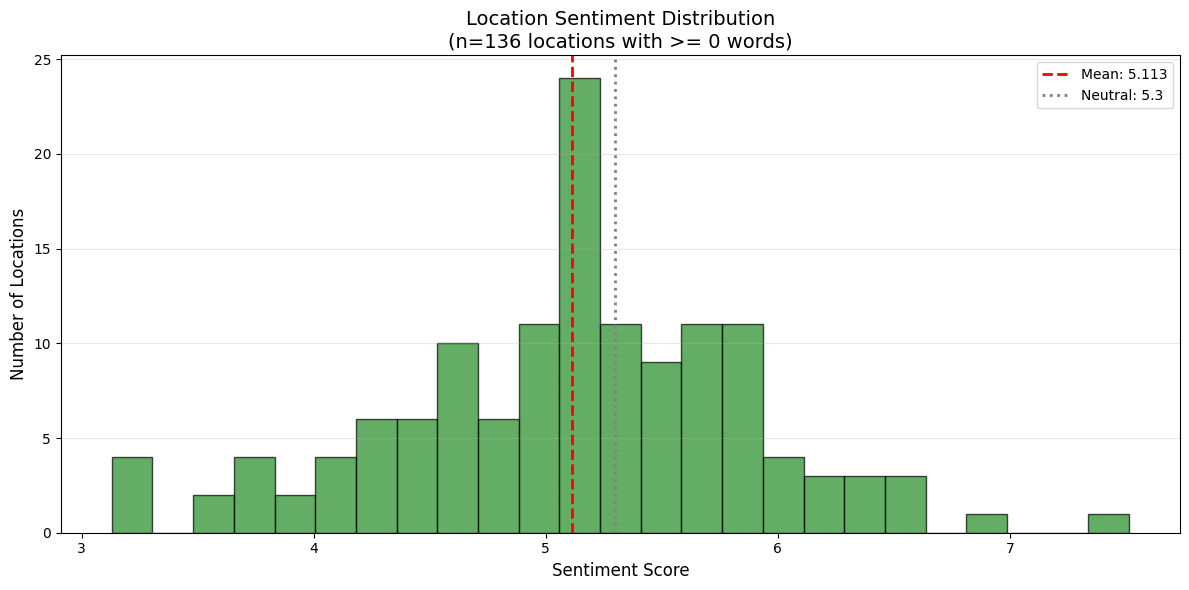


Location sentiment range: 3.130 to 7.513


In [21]:
# Visualize location sentiment distribution
fig, ax = plt.subplots(figsize=(12, 6))

loc_scores = [v['sentiment'] for v in location_sentiments.values() 
              if v['sentiment'] is not None and v['word_count'] >= MIN_WORDS_SECONDARY]

ax.hist(loc_scores, bins=25, color='forestgreen', edgecolor='black', alpha=0.7)
ax.axvline(np.mean(loc_scores), color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {np.mean(loc_scores):.3f}')
ax.axvline(NEUTRAL, color='gray', linestyle=':', linewidth=2, label=f'Neutral: {NEUTRAL}')

ax.set_xlabel('Sentiment Score', fontsize=12)
ax.set_ylabel('Number of Locations', fontsize=12)
ax.set_title(f'Location Sentiment Distribution\n(n={len(loc_scores)} locations with >= {MIN_WORDS_SECONDARY} words)', 
             fontsize=14)
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / "location_sentiment_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\nLocation sentiment range: {min(loc_scores):.3f} to {max(loc_scores):.3f}")

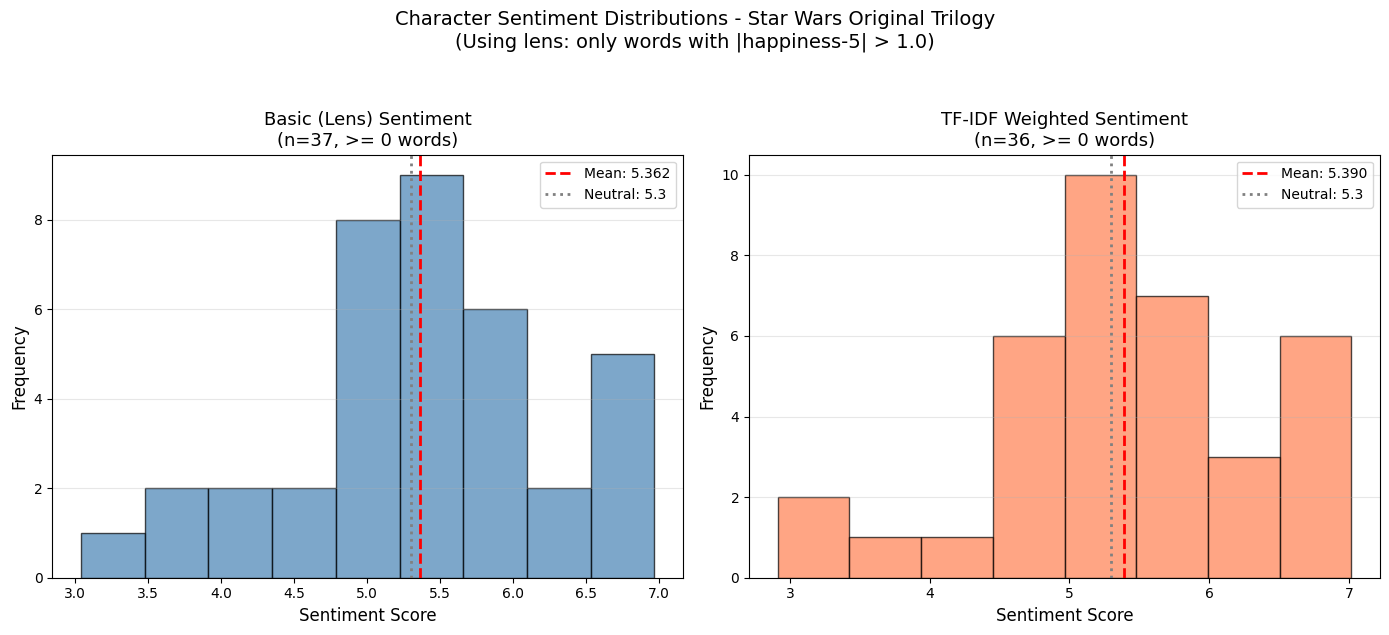


Note: Only showing 37 characters with >= 0 words


In [22]:
# Plot distributions side by side (only high-quality characters)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Filter to primary quality characters
basic_scores = [
    v['sentiment'] for v in char_sentiments_lens.values() 
    if v['sentiment'] is not None and v['word_count'] >= MIN_WORDS_PRIMARY
]
tfidf_scores_list = [
    v['sentiment'] for v in tfidf_results.values()
    if v['sentiment'] is not None and v['word_count'] >= MIN_WORDS_PRIMARY
]

# Basic (lens) sentiment distribution
ax = axes[0]
ax.hist(basic_scores, bins='auto', color='steelblue', edgecolor='black', alpha=0.7)
ax.axvline(np.mean(basic_scores), color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {np.mean(basic_scores):.3f}')
ax.axvline(NEUTRAL, color='gray', linestyle=':', linewidth=2, label=f'Neutral: {NEUTRAL}')
ax.set_xlabel('Sentiment Score', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title(f'Basic (Lens) Sentiment\n(n={len(basic_scores)}, >= {MIN_WORDS_PRIMARY} words)', fontsize=13)
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)

# TF-IDF sentiment distribution
ax = axes[1]
ax.hist(tfidf_scores_list, bins='auto', color='coral', edgecolor='black', alpha=0.7)
ax.axvline(np.mean(tfidf_scores_list), color='red', linestyle='--', linewidth=2,
           label=f'Mean: {np.mean(tfidf_scores_list):.3f}')
ax.axvline(NEUTRAL, color='gray', linestyle=':', linewidth=2, label=f'Neutral: {NEUTRAL}')
ax.set_xlabel('Sentiment Score', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title(f'TF-IDF Weighted Sentiment\n(n={len(tfidf_scores_list)}, >= {MIN_WORDS_PRIMARY} words)', fontsize=13)
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.suptitle('Character Sentiment Distributions - Star Wars Original Trilogy\n(Using lens: only words with |happiness-5| > 1.0)', 
             fontsize=14, y=1.05)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "sentiment_distributions.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\nNote: Only showing {len(basic_scores)} characters with >= {MIN_WORDS_PRIMARY} words")

In [23]:
# Define character groups
CHARACTER_GROUPS = {
    'Jedi': ['LUKE', 'LUKE SKYWALKER', 'YODA', 'BEN', 'OBI-WAN', 'OBIWAN', 'OBI-WAN KENOBI'],
    'Sith/Empire': ['VADER', 'DARTH VADER', 'LORD VADER', 'EMPEROR', 'EMPEROR PALPATINE', 'PALPATINE', 'TARKIN', 'GRAND MOFF TARKIN'],
    'Rebels/Heroes': ['HAN', 'HAN SOLO', 'LEIA', 'LEIA ORGANA', 'PRINCESS LEIA', 'LANDO', 'LANDO CALRISSIAN', 
                      'CHEWBACCA', 'CHEWIE', 'WEDGE', 'WEDGE ANTILLES', 'BIGGS', 'BIGGS DARKLIGHTER', 
                      'ACKBAR', 'RIEEKAN', 'DODONNA'],
    'Droids': ['THREEPIO', 'C-3PO', 'C3PO', 'THREE-PO', 'ARTOO', 'R2-D2', 'R2D2', 'ARTOO-DETOO']
}

# Color schemes for word clouds
GROUP_COLORS = {
    'Jedi': 'Blues',
    'Sith/Empire': 'Reds',
    'Rebels/Heroes': 'Greens',
    'Droids': 'copper'
}

print("\nCharacter Groups defined:")
for group, chars in CHARACTER_GROUPS.items():
    group_words_count = sum(word_counts.get(c, 0) for c in chars)
    print(f"  {group}: {len(chars)} characters ({group_words_count:,} total words)")


Character Groups defined:
  Jedi: 7 characters (3,938 total words)
  Sith/Empire: 8 characters (1,973 total words)
  Rebels/Heroes: 16 characters (5,204 total words)
  Droids: 8 characters (2,967 total words)


In [24]:
def get_group_tfidf_words(group_characters: list, top_n: int = 100) -> dict:
    """
    Get TF-IDF weighted word frequencies for a group of characters.
    Aggregates TF-IDF scores across all characters in the group.
    
    Returns dict: word -> aggregated TF-IDF weight
    """
    char_list = list(character_dialogues.keys())
    aggregated_weights = Counter()
    
    for char in group_characters:
        if char not in char_list:
            continue
        
        char_idx = char_list.index(char)
        tfidf_weights = tfidf_matrix[char_idx].toarray().flatten()
        
        for word_idx, weight in enumerate(tfidf_weights):
            if weight > 0:
                word = feature_names[word_idx]
                # Skip stopwords
                if word not in STOP_WORDS:
                    aggregated_weights[word] += weight
    
    # Return top N words
    return dict(aggregated_weights.most_common(top_n))


def get_sentiment_colored_frequencies(word_freq: dict, use_sentiment: bool = True) -> dict:
    """
    Get word frequencies, optionally colored by sentiment.
    For word cloud display, we just return the frequencies.
    """
    return word_freq


# Compute TF-IDF words for each group
group_words = {}
for group, chars in CHARACTER_GROUPS.items():
    group_words[group] = get_group_tfidf_words(chars, top_n=150)

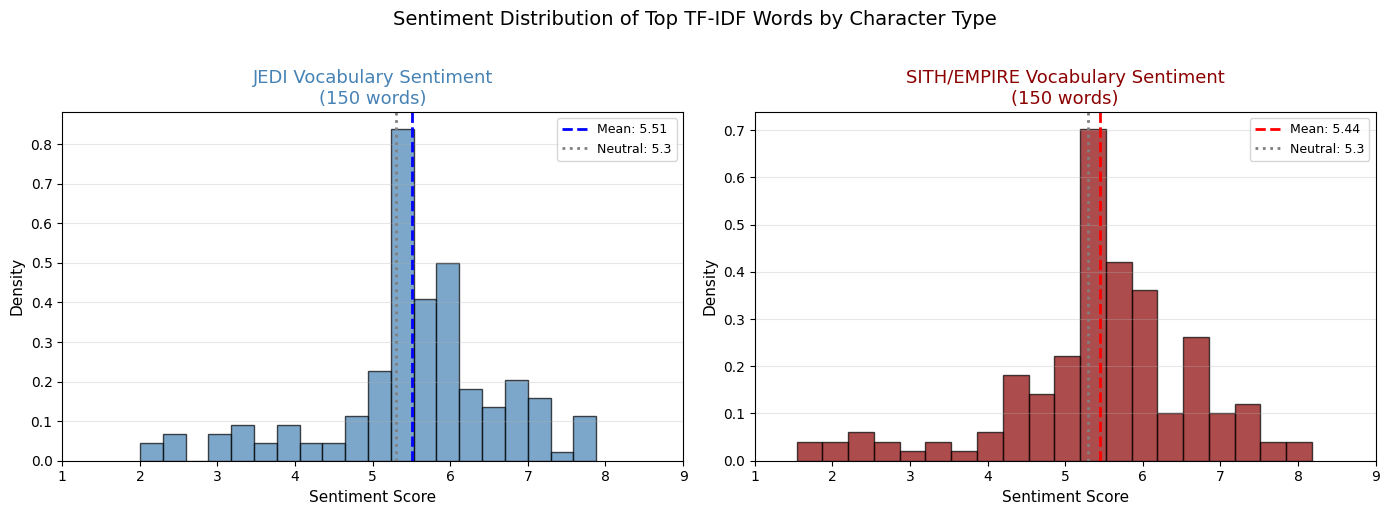

In [25]:
# Compare sentiment distributions of words used by each group
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Get sentiment scores for top words in each group (using stemming)
def get_sentiment_list(words):
    sentiments = []
    for w in words:
        s, _ = lookup_sentiment(w, word_to_happiness)
        sentiments.append(s if s is not None else NEUTRAL)
    return sentiments

jedi_sentiments = get_sentiment_list(group_words['Jedi'].keys())
sith_sentiments = get_sentiment_list(group_words['Sith/Empire'].keys())

# Jedi histogram
ax = axes[0]
ax.hist(jedi_sentiments, bins=20, color='steelblue', edgecolor='black', alpha=0.7, density=True)
ax.axvline(np.mean(jedi_sentiments), color='blue', linestyle='--', linewidth=2, 
           label=f'Mean: {np.mean(jedi_sentiments):.2f}')
ax.axvline(NEUTRAL, color='gray', linestyle=':', linewidth=2, label=f'Neutral: {NEUTRAL}')
ax.set_xlabel('Sentiment Score', fontsize=11)
ax.set_ylabel('Density', fontsize=11)
ax.set_title(f'JEDI Vocabulary Sentiment\n({len(jedi_sentiments)} words)', fontsize=13, color='steelblue')
ax.legend(fontsize=9)
ax.set_xlim(1, 9)
ax.grid(axis='y', alpha=0.3)

# Sith histogram
ax = axes[1]
ax.hist(sith_sentiments, bins=20, color='darkred', edgecolor='black', alpha=0.7, density=True)
ax.axvline(np.mean(sith_sentiments), color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {np.mean(sith_sentiments):.2f}')
ax.axvline(NEUTRAL, color='gray', linestyle=':', linewidth=2, label=f'Neutral: {NEUTRAL}')
ax.set_xlabel('Sentiment Score', fontsize=11)
ax.set_ylabel('Density', fontsize=11)
ax.set_title(f'SITH/EMPIRE Vocabulary Sentiment\n({len(sith_sentiments)} words)', fontsize=13, color='darkred')
ax.legend(fontsize=9)
ax.set_xlim(1, 9)
ax.grid(axis='y', alpha=0.3)

plt.suptitle('Sentiment Distribution of Top TF-IDF Words by Character Type', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "wordcloud_sentiment_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

Computing sentiment ranges for each group...
  Jedi: min=2.00, max=7.88
  Sith/Empire: min=1.54, max=8.18
  Rebels/Heroes: min=1.54, max=7.68
  Droids: min=1.74, max=8.22


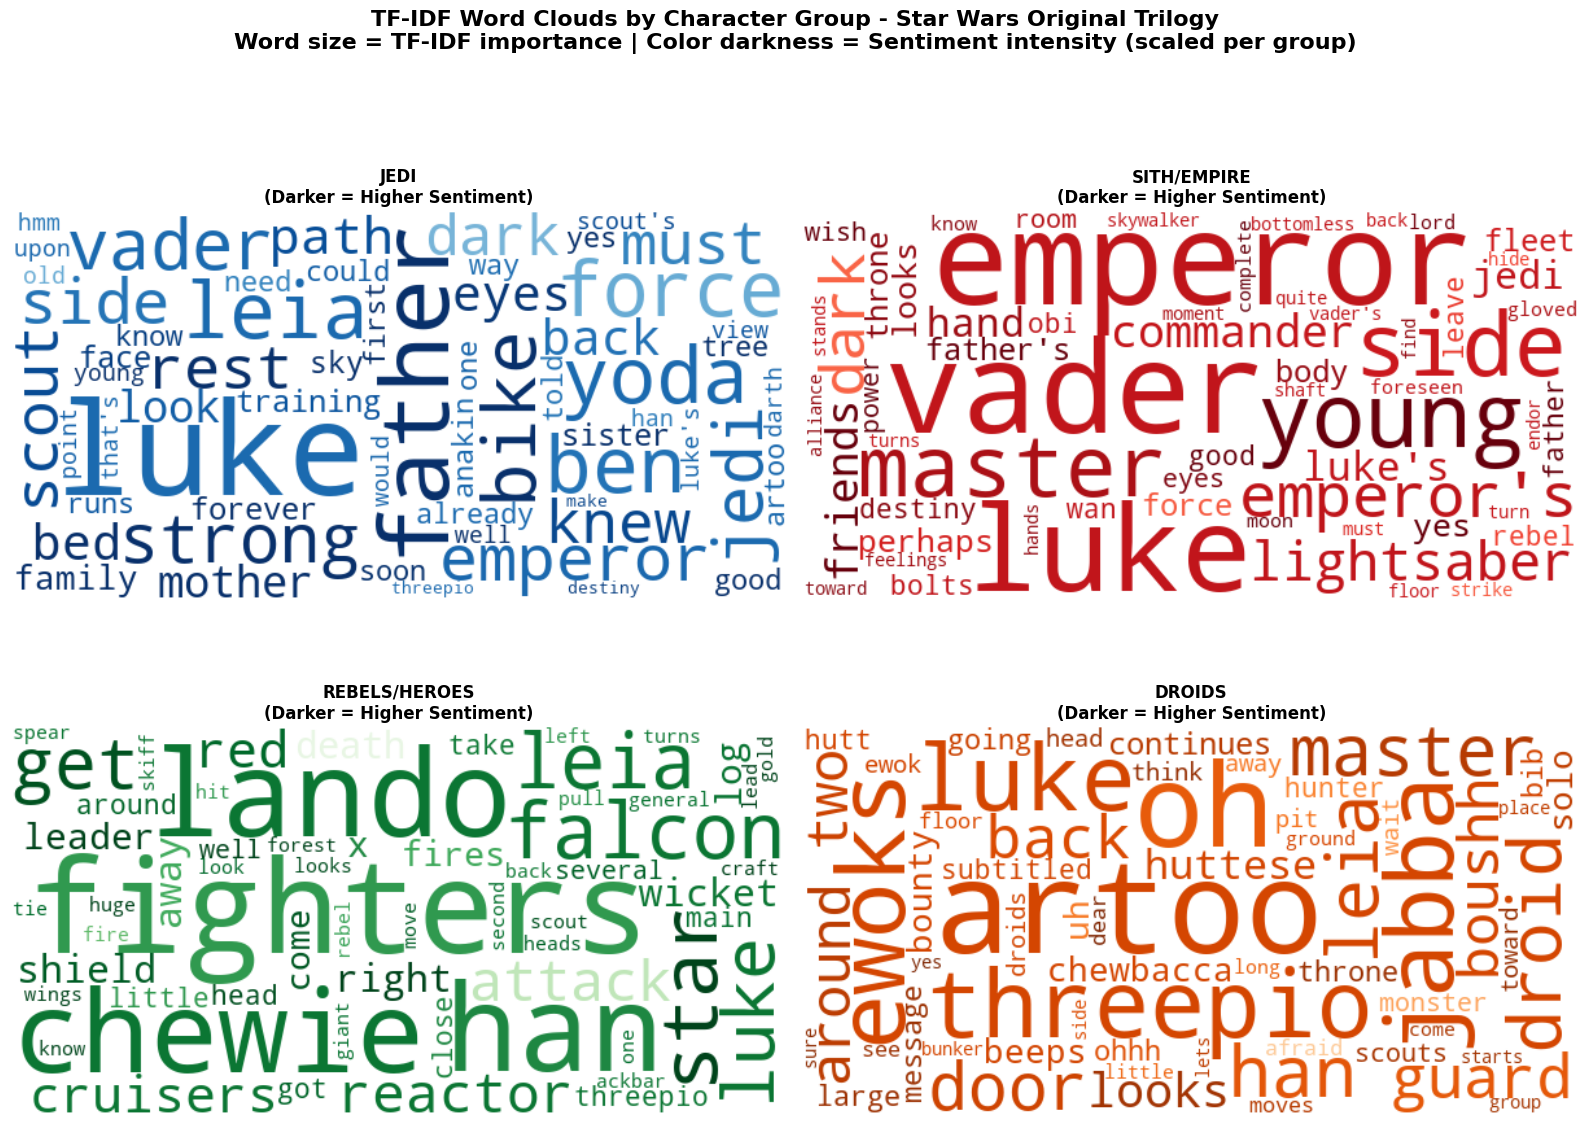

In [26]:


# Define colormap for each group
GROUP_COLORMAPS = {
    'Jedi': 'Blues',
    'Sith/Empire': 'Reds',
    'Rebels/Heroes': 'Greens',
    'Droids': 'Oranges',
}

def compute_group_sentiment_range(group_name: str, word_freq: dict):
    """
    Compute min and max sentiment values for a group's words.
    Returns (min_sentiment, max_sentiment)
    """
    sentiments = []
    for word in word_freq.keys():
        sentiment, _ = lookup_sentiment(word.lower(), word_to_happiness)
        if sentiment is not None:
            sentiments.append(sentiment)
    
    if sentiments:
        return min(sentiments), max(sentiments)
    else:
        return NEUTRAL, NEUTRAL

def create_sentiment_colormap_func(group_name: str, min_sentiment: float, max_sentiment: float):
    """
    Create a color function that uses the group's colormap with intensity based on sentiment.
    Min sentiment = very light color, Max sentiment = dark color.
    """
    colormap_name = GROUP_COLORMAPS[group_name]
    colormap = plt.get_cmap(colormap_name)
    
    def sentiment_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        # Use stemming-aware lookup
        sentiment, _ = lookup_sentiment(word.lower(), word_to_happiness)
        if sentiment is None:
            sentiment = NEUTRAL
        
        # Scale sentiment to 0-1 range based on group's min/max
        # 0.0 = min_sentiment (very light), 1.0 = max_sentiment (dark)
        if max_sentiment > min_sentiment:
            normalized = (sentiment - min_sentiment) / (max_sentiment - min_sentiment)
        else:
            normalized = 0.5  # If all same, use middle
        
        # Clamp to [0, 1]
        normalized = max(0.0, min(1.0, normalized))
        
        # Map to colormap with wider range for better contrast
        # 0.0 = very light (0.1), 1.0 = very dark (1.0)
        # This creates a range from 0.1 to 1.0 for maximum contrast
        colormap_value = 0.1 + (normalized * 1.2)  # Range from 0.1 to 1.0
        
        # Get color from colormap (returns RGBA, convert to RGB)
        rgba = colormap(colormap_value)
        r, g, b = int(rgba[0] * 255), int(rgba[1] * 255), int(rgba[2] * 255)
        
        return f"rgb({r}, {g}, {b})"
    
    return sentiment_color_func


# Word cloud parameters
wc_params = {
    'width': 600,
    'height': 300,
    'background_color': 'white',
    'max_words': 60,
    'prefer_horizontal': 0.7,
    'min_font_size': 8,
    'max_font_size': 100,
    'relative_scaling': 0.5,
}

# First, compute sentiment ranges for each group
print("Computing sentiment ranges for each group...")
group_ranges = {}
for group_name in CHARACTER_GROUPS.keys():
    if group_name in group_words:
        min_sent, max_sent = compute_group_sentiment_range(group_name, group_words[group_name])
        group_ranges[group_name] = (min_sent, max_sent)
        print(f"  {group_name}: min={min_sent:.2f}, max={max_sent:.2f}")

# Create 2x2 grid for all 4 character groups
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Panel configs: (group_name, row, col)
panels = [
    ('Jedi', 0, 0),
    ('Sith/Empire', 0, 1),
    ('Rebels/Heroes', 1, 0),
    ('Droids', 1, 1),
]

for group_name, row, col in panels:
    ax = axes[row, col]
    
    # Get sentiment range for this group
    min_sent, max_sent = group_ranges.get(group_name, (NEUTRAL, NEUTRAL))
    
    # Create group-specific color function with sentiment-based intensity
    color_func = create_sentiment_colormap_func(group_name, min_sent, max_sent)
    
    # Generate word cloud
    wc = WordCloud(**wc_params).generate_from_frequencies(group_words[group_name])
    wc.recolor(color_func=color_func)
    
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(f'{group_name.upper()}\n(Darker = Higher Sentiment)', 
                 fontsize=12, fontweight='bold')
    ax.axis('off')

plt.suptitle('TF-IDF Word Clouds by Character Group - Star Wars Original Trilogy\n' +
             'Word size = TF-IDF importance | Color darkness = Sentiment intensity (scaled per group)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "wordcloud_all_groups_sentiment.png", dpi=300, bbox_inches='tight')
plt.show()